<a href="https://colab.research.google.com/github/yohanesnuwara/2016-ml-contest/blob/master/HPFEM_KTH/W1/HPFEM_W1_wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [88.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease

In [0]:
set_log_active(False)

def plot_compact(u, t, stepcounter):
  if stepcounter % 5 == 0:
    uEuclidnorm = project(u, Q);
    ax.cla;
    fig = plt.gcf();
    fig.set_size_inches(16,2)

    # plot norm of velocity
    ax1 = plt.subplot(1,2,1);
    fenicsplot.mplot_function(ax1, uEuclidnorm);
    plt.title("Wave")
    plt.suptitle("Wave - t: %f" % (t));
    plt.tight_layout();
    clear_output(wait=True);
    display(pl)

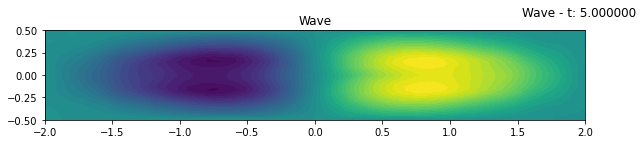

In [10]:
# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -0.5, 0.5; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
degree = 1
Ve = FiniteElement("CG", mesh.ufl_cell(), degree)
Q = FunctionSpace(mesh, Ve)
TH = MixedElement([Ve, Ve])
W = FunctionSpace(mesh, TH)
# h = CellSize(mesh);
(p, q) = TestFunctions(W);
w = Function(W);
(u, v) = (w[0], w[1]);
u0 = Function(Q);
v0 = Function(Q);

# Time interval and time step
t, T = 0, 5;
k = 0.05;
a = 1;

# Define the Dirichlet boundary
def boundary(x, on_boundary):
  return on_boundary

# Initial solution
option = 1;
if option==0:
  ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))",
                  a=a, t=0, domain=mesh, degree=degree);
  ve = Expression("2*a*(a*t+x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))",
                  a=a, t=0, domain=mesh, degree=degree)
if option==1:
  ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2))",
                  a=a, t=0, domain=mesh, degree=degree);
  ve = Expression("2*a*(a*t+x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2))",
                  a=a, t=0, domain=mesh, degree=degree)


# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;

# Time-stepping loop
while t < T:
  # weak form of wave equation
  vm = theta*v + (1.0-theta)*v0;
  um = theta*u + (1.0-theta)*u0;
  ru = (u-u0)/k*p*dx - vm*p*dx
  rv = (v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
  r = ru + rv;
  ue.t = t;
  ve.t = t;

  # solve the wave equation (one time step)
  solve(r==0, w, bcs);

  # visualize the solution
  pl, ax = plt.subplots();
  plot_compact(u, t, 0)
  plt.close()

  # shift to the next timestep
  u0 = project(u, Q);
  v0 = project(v, Q);
  t += k;